Aim: calculating the average GC content of intergenic into which ISs insert themselves and compare it to the average GC content of intergenic regions of the whole genome.

Importing necessary packages and defining paths:

In [1]:
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
%matplotlib inline

In [2]:
ref = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/ref/"
data = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/LTEE-clone-curated/"

Opening reference REL606 sequence:

In [3]:
record = SeqIO.read(ref+'REL606.gbk', 'genbank') #loading ancestor reference file

In [4]:
len(record.seq)

4629812

Defining function to extract IS positions: 

In [5]:
def extract_positions(IS_name):
    '''Generates a dictionary listing the position of insertions that occured at some point in at least
    one of the clones of one of the populations (only one occurrence per position, even if it occured
    in different populations).'''

    
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(data) if isfile(join(data, f))] #listing all file names for the .gd files
    files = [] # creating a list that will first contain these names to be called, and later on open .gd files
    file_names = [] # list that will contain names as strings (kept as such for all the analysis)
    readlines_names = [] #list that will contain lists with the lines of each file (obtained via readlines())
    for i in onlyfiles: #fixing an error in the list of files (I don't know why it occurs) and filling the previously defined lists
        if len(i) < 30:
            files.append(i)
            file_names.append(i)
            readlines_names.append(i)
    
    
    for i in range(len(files)):
        files[i] = open(data+files[i],"r") #the list files becomes a list of open files
        readlines_names[i] = files[i].readlines() # the list readlines_names becomes a list of lists, with each list containing 
        #all the lines from one file
    
    
    insertion_positions = {} # Creating a dictionary to hold the positions of the insertions
    for i in range(len(file_names)): # for each file
        for line in readlines_names[i]: #we look at all the lines in the corresponding readlines_names entry
            line = line.split()
            if 'MOB' in line and IS_name in line: #if the line corresponds to a mutation linked to the IS
                insertion_positions[line[4]] = [line[4], line[6]] #we add an entry for this IS position to our dictionary
                # and save the orientation as well
                # /!\ this will erase the previous insertion if there was already an insertion at this position
    
    return insertion_positions
    

Defining a function to calculate the GC content of a sequence:

In [6]:
def calc_gc_content(sequence):
    """Return the % G+C content in a passed sequence.
    Arguments:
        - sequence  - a Bio.Seq.Seq object.
    calc_gc_content(sequence)
    """
    d = {}
    for nt in ["A", "T", "G", "C"]:
        d[nt] = sequence.count(nt) + sequence.count(nt.lower())
    gc = d.get("G", 0) + d.get("C", 0)

    if gc == 0:
        return 0
    # print(gc*100.0/(d['A'] +d['T'] + gc))
    return gc * 1.0 / (d["A"] + d["T"] + gc)

Defining a function that generates a list containing the GC content of all intergenic sequences into which an IS inserted:

In [7]:
def GC_content(IS_name):
    '''Returns a list containing the GC content of all intergenic sequences into which an IS inserted.'''

    positions_IS = extract_positions(IS_name) # generating a dictionary of the format {insertion_position: [position, orientation]}
    gc_content_list = [] # initializing the GC content list
    
    length_intergenic = []
    
    list_CDS = [] #generating a list of record.features indices corresponding to CDS to go around the problem of the gbk file
    index = 1
    for feature in record.features[1:]: #for each feature in the reference genome
            if feature.type == 'CDS': # if the feature is a coding sequence
                list_CDS.append(index) # we save the index in the feature list
            index+= 1

    for insertion_position in list(positions_IS.keys()): #for each insertion
        IS_position = int(insertion_position) #we get the insertion position as an integer
        position_found = False
        orf_before = 0 #initializing the position of the ORF right before the insertion 
        counter = 0 # counter of where we are in the CDS list
        counter_save = 0 #will hold the index of the closest CDS before the insertion in the list of CDSs
        
        for index in list_CDS: #for each CDS
            feature = record.features[index] #we go get the feature in the record.features list
            if 'join' not in str(feature.location): #getting rid of an annoying but unique anomaly in the features
                start_position = int(str(feature.location).split(':')[0][1:]) # getting the start position of the CDS
                end_position = int(str(feature.location).split(':')[1][:-4]) # getting the end position of the CDS
                if IS_position >= end_position and orf_before < end_position: 
                    #if we found an ORF end closer to the insertion than the one saved
                    orf_before = end_position #we save the end position of the ORF before
                    counter_save = counter #we save the feature's position in the list of CDS indices
                if IS_position >= start_position and IS_position <= end_position: # if the IS interrupts that CDS
                    position_found = True
            counter += 1
                    

        if not position_found: # if the insertion did not take place in a CDS
            start_intergenic = orf_before+1 # the start of the intergenic sequence
            end_intergenic = int(str(record.features[list_CDS[counter_save+1]].location).split(':')[0][1:])
            # in the list of CDS, we take the one right after the CDS before the IS and take the beginning position
            gc_content = calc_gc_content(record[start_intergenic:end_intergenic].seq)
            # we take the GC content of the sequence between the two ORFs
            gc_content_list.append(gc_content) # we save the content to our list
            length_intergenic.append(end_intergenic-start_intergenic)
        
    
    print(length_intergenic)
    
    return gc_content_list


In [8]:
from math import floor

Retrieving the GC content of intergenic sequences across the whole genome:

In [9]:
list_CDS = []
index = 1
for feature in record.features[1:]: #for each feature in the reference genome
        if feature.type == 'CDS': # if the feature is a coding sequence
            list_CDS.append(index)
        index+= 1

gc_content_intergenic = []
index_CDS_list = 0
for index_feature in list_CDS[:-1]: #for each feature in the reference genome
    feature = record.features[index_feature]
    feature_next = record.features[list_CDS[index_CDS_list+1]]
    if 'join' not in str(feature.location) and 'join' not in str(feature_next.location):
        end_position = int(str(feature.location).split(':')[1][:-4]) # getting the end position of the CDS
        next_CDS_start = int(str(feature_next.location).split(':')[0][1:])
        gc_content = calc_gc_content(record[end_position:next_CDS_start].seq)
        if gc_content != 0 and gc_content != 1:#removing cases where two ORFs are squeezed to one another
            gc_content_intergenic.append(gc_content)
    index_CDS_list += 1

Plotting the distribution of GC content in intergenic sequences across the genome:

Text(0.5, 0, 'GC content')

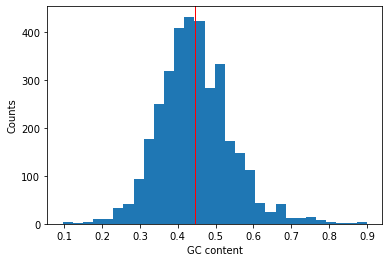

In [10]:
plt.hist(gc_content_intergenic, density=False, bins=30)  # density=False would make counts
plt.axvline(sum(gc_content_intergenic)/len(gc_content_intergenic), color='red', linewidth=1)
plt.ylabel('Counts')
plt.xlabel('GC content')

Calculating the GC content of intergenic sequences interrupted by IS150 insertions (and printing the length of theses intergenic sequences to check that it's consistent):

In [11]:
GC_content_IS150 = GC_content('IS150')

[528, 59, 258, 403, 339, 210, 190, 60, 600, 1543, 287, 147, 425, 46, 339, 528, 426, 63, 144, 528, 600, 426, 403, 107, 736, 528, 209, 104, 339, 125, 282, 190, 107, 89, 70, 54, 424, 210, 48, 53, 528, 46, 403, 90, 236, 389, 375, 339, 204]


Comparing the distribution of GC content in intergenic regions across the genome and intergenic sequences targeted by IS150:

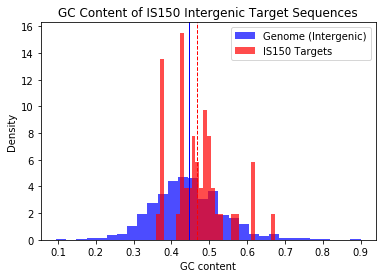

In [12]:
plt.hist(gc_content_intergenic, density=True, bins=30, color = 'blue', alpha = 0.7, label = 'Genome (Intergenic)')  # density=False would make counts
plt.hist(GC_content_IS150, density=True, bins=30, color = 'red', alpha = 0.7, label = 'IS150 Targets')  # density=False would make counts
plt.axvline(sum(gc_content_intergenic)/len(gc_content_intergenic), color='blue', linewidth=1)
plt.axvline(sum(GC_content_IS150)/len(GC_content_IS150), color='red', linestyle='dashed', linewidth=1)
plt.ylabel('Density')
plt.xlabel('GC content')
plt.title('GC Content of IS150 Intergenic Target Sequences')
plt.legend()

plt.savefig('GC_content_IS150_intergenic.png',dpi=400)

Calculating the GC content of intergenic sequences interrupted by IS1 insertions (and printing the length of theses intergenic sequences to check that it's consistent):

In [13]:
GC_content_IS1 = GC_content('IS1')

[191, 191, 1059, 213, 191, 845, 291, 176, 572, 182, 1670, 133, 428, 355, 365, 365, 795, 600, 217, 433, 191, 646, 329, 191, 742]


Comparing the distribution of GC content in intergenic regions across the genome and intergenic sequences targeted by IS1:

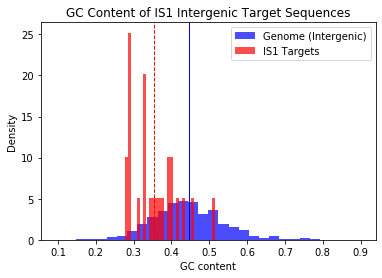

In [14]:
plt.hist(gc_content_intergenic, density=True, bins=30, color = 'blue', alpha = 0.7, label = 'Genome (Intergenic)')  # density=False would make counts
plt.hist(GC_content_IS1, density=True, bins=30, color = 'red', alpha = 0.7, label = 'IS1 Targets')  # density=False would make counts

plt.axvline(sum(gc_content_intergenic)/len(gc_content_intergenic), color='blue', linewidth=1)
plt.axvline(sum(GC_content_IS1)/len(GC_content_IS1), color='red', linestyle='dashed', linewidth=1)
plt.ylabel('Density')
plt.xlabel('GC content')
plt.legend()
plt.title('GC Content of IS1 Intergenic Target Sequences')

plt.savefig('GC_content_IS1_intergenic.png',dpi=400)

Calculating the GC content of intergenic sequences interrupted by IS186 insertions (and printing the length of theses intergenic sequences to check that it's consistent):

In [15]:
GC_content_IS186 = GC_content('IS186')

[48, 33, 40, 40, 366, 254, 369]


Comparing the distribution of GC content in intergenic regions across the genome and intergenic sequences targeted by IS186:

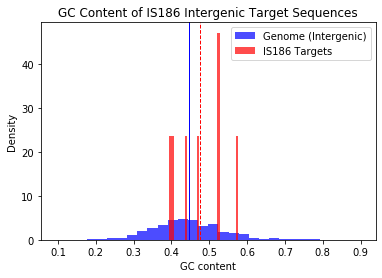

In [16]:
plt.hist(gc_content_intergenic, density=True, bins=30, color = 'blue', alpha = 0.7, label = 'Genome (Intergenic)')  # density=False would make counts
plt.hist(GC_content_IS186, density=True, bins=30, color = 'red', alpha = 0.7, label = 'IS186 Targets')  # density=False would make counts
plt.axvline(sum(gc_content_intergenic)/len(gc_content_intergenic), color='blue', linewidth=1)
plt.axvline(sum(GC_content_IS186)/len(GC_content_IS186), color='red', linestyle='dashed', linewidth=1)
plt.ylabel('Density')
plt.xlabel('GC content')
plt.title('GC Content of IS186 Intergenic Target Sequences')
plt.legend()

plt.savefig('GC_content_IS186_intergenic.png',dpi=400)

# Statistical tests

In [17]:
import scipy.stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [18]:
t, p = ttest_ind(gc_content_intergenic, GC_content_IS150, equal_var=False)
p

0.027993646091337678

In [19]:
t, p = ttest_ind(gc_content_intergenic, GC_content_IS1, equal_var=False)
p

1.312399311114644e-07

In [20]:
t, p = ttest_ind(gc_content_intergenic, GC_content_IS186, equal_var=False)
p

0.30962367604302127